In [129]:
# ## install finrl library
# !pip install plotly==4.4.1
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install PyPortfolioOpt

In [130]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [131]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [132]:
tickers = ["^TNX", "XU030.IS"]

In [133]:
df = YahooDownloader(start_date = '2010-01-01',
                           end_date = '2020-01-01',
                           ticker_list = tickers).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (5027, 8)


In [134]:
df.shape

(5027, 8)

In [135]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,66964.296875,67611.296875,66330.703125,67561.398438,277200,XU030.IS,0
1,2010-01-04,3.859000,3.859000,3.808000,3.841000,0,^TNX,0
2,2010-01-05,67880.000000,69030.203125,67760.500000,68574.203125,375900,XU030.IS,1
3,2010-01-05,3.790000,3.800000,3.749000,3.755000,0,^TNX,1
4,2010-01-06,68440.296875,69082.796875,68003.500000,68929.898438,274300,XU030.IS,2


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5027 entries, 0 to 5026
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5027 non-null   object 
 1   open    5027 non-null   float64
 2   high    5027 non-null   float64
 3   low     5027 non-null   float64
 4   close   5027 non-null   float64
 5   volume  5027 non-null   int64  
 6   tic     5027 non-null   object 
 7   day     5027 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(2)
memory usage: 294.7+ KB


In [137]:
df['date'] = pd.to_datetime(df['date'])

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5027 entries, 0 to 5026
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5027 non-null   datetime64[ns]
 1   open    5027 non-null   float64       
 2   high    5027 non-null   float64       
 3   low     5027 non-null   float64       
 4   close   5027 non-null   float64       
 5   volume  5027 non-null   int64         
 6   tic     5027 non-null   object        
 7   day     5027 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(1)
memory usage: 294.7+ KB


In [139]:
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

In [140]:
df = df.sort_values(['date','tic'],ignore_index=True)

In [141]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,66964.296875,67611.296875,66330.703125,67561.398438,277200,XU030.IS,0
1,2010-01-04,3.859000,3.859000,3.808000,3.841000,0,^TNX,0
2,2010-01-05,67880.000000,69030.203125,67760.500000,68574.203125,375900,XU030.IS,1
3,2010-01-05,3.790000,3.800000,3.749000,3.755000,0,^TNX,1
4,2010-01-06,68440.296875,69082.796875,68003.500000,68929.898438,274300,XU030.IS,2


In [142]:
df.tic.value_counts()

tic
XU030.IS    2514
^TNX        2513
Name: count, dtype: int64

In [143]:
# Filter the DataFrame to keep only rows where the date is common for all tickers
df = df[df.groupby('date')['tic'].transform('nunique') == len(tickers)]

In [144]:
df.shape

(4856, 8)

In [145]:
df.tic.value_counts()

tic
XU030.IS    2428
^TNX        2428
Name: count, dtype: int64

In [146]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,66964.296875,67611.296875,66330.703125,67561.398438,277200,XU030.IS,0
1,2010-01-04,3.859000,3.859000,3.808000,3.841000,0,^TNX,0
2,2010-01-05,67880.000000,69030.203125,67760.500000,68574.203125,375900,XU030.IS,1
3,2010-01-05,3.790000,3.800000,3.749000,3.755000,0,^TNX,1
4,2010-01-06,68440.296875,69082.796875,68003.500000,68929.898438,274300,XU030.IS,2


In [147]:
# Perform Feature Engineering:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = config.INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


/usr/local/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [148]:
processed.isnull().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
tic             0
day             0
macd            0
boll_ub         0
boll_lb         0
rsi_30          0
cci_30          0
dx_30           0
close_30_sma    0
close_60_sma    0
turbulence      0
dtype: int64

In [149]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4856 entries, 0 to 4855
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          4856 non-null   object 
 1   open          4856 non-null   float64
 2   high          4856 non-null   float64
 3   low           4856 non-null   float64
 4   close         4856 non-null   float64
 5   volume        4856 non-null   int64  
 6   tic           4856 non-null   object 
 7   day           4856 non-null   int32  
 8   macd          4856 non-null   float64
 9   boll_ub       4856 non-null   float64
 10  boll_lb       4856 non-null   float64
 11  rsi_30        4856 non-null   float64
 12  cci_30        4856 non-null   float64
 13  dx_30         4856 non-null   float64
 14  close_30_sma  4856 non-null   float64
 15  close_60_sma  4856 non-null   float64
 16  turbulence    4856 non-null   float64
dtypes: float64(13), int32(1), int64(1), object(2)
memory usage: 626.1+ KB


In [150]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2010-01-04,66964.296875,67611.296875,66330.703125,67561.398438,277200,XU030.IS,0,0.000000,69500.122906,66635.478656,100.0,66.666667,100.0,67561.398438,67561.398438,0.0
1,2010-01-04,3.859000,3.859000,3.808000,3.841000,0,^TNX,0,0.000000,69500.122906,66635.478656,100.0,66.666667,100.0,3.841000,3.841000,0.0
2,2010-01-05,67880.000000,69030.203125,67760.500000,68574.203125,375900,XU030.IS,1,22.723182,69500.122906,66635.478656,100.0,66.666667,100.0,68067.800781,68067.800781,0.0
3,2010-01-05,3.790000,3.800000,3.749000,3.755000,0,^TNX,1,-0.001929,3.919622,3.676378,0.0,-66.666667,100.0,3.798000,3.798000,0.0
4,2010-01-06,68440.296875,69082.796875,68003.500000,68929.898438,274300,XU030.IS,2,39.983935,69775.280451,66935.052882,100.0,61.665847,100.0,68355.166667,68355.166667,0.0


In [151]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 2, State Space: 21


In [152]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [153]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [154]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [155]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2018-01-01'
TEST_START_DATE = '2018-01-01'
TEST_END_DATE = '2020-01-01'

In [156]:
rebalance_window = 66 # rebalance_window is the number of days to retrain the model
validation_window = 22 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [157]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [158]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  13.186391073705295
======Model training from:  2010-01-01 to  2018-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_88_3
--------------------------------------
| time/                 |            |
|    fps                | 335        |
|    iterations         | 100        |
|    time_elapsed       | 1          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -2.86      |
|    explained_variance | 0.172      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 8.5        |
|    reward             | -0.4644374 |
|    std                | 1.01       |
|    value_loss         | 11.1       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps   

In [159]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,88,2018-01-02,2018-02-02,A2C,0.043318,-0.101849,0.0
1,154,2018-04-09,2018-05-11,DDPG,-0.538035,-1.066634,0.339626
2,220,2018-07-17,2018-08-16,A2C,-0.034784,-0.274153,-0.36361
3,286,2018-10-25,2018-11-28,PPO,0.012265,0.292055,0.012261
4,352,2019-02-04,2019-03-07,A2C,0.055158,-0.491314,0.0
5,418,2019-05-13,2019-06-18,PPO,0.424143,0.768938,-0.799526


In [160]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [161]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.2669231516942852


In [162]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2018-02-02,NaN,2018-02-02
1,989799.733144,2018-02-05,-0.010200,2018-02-05
2,980801.803976,2018-02-06,-0.009091,2018-02-06
3,980127.288972,2018-02-07,-0.000688,2018-02-07
4,971076.851472,2018-02-08,-0.009234,2018-02-08


<Axes: >

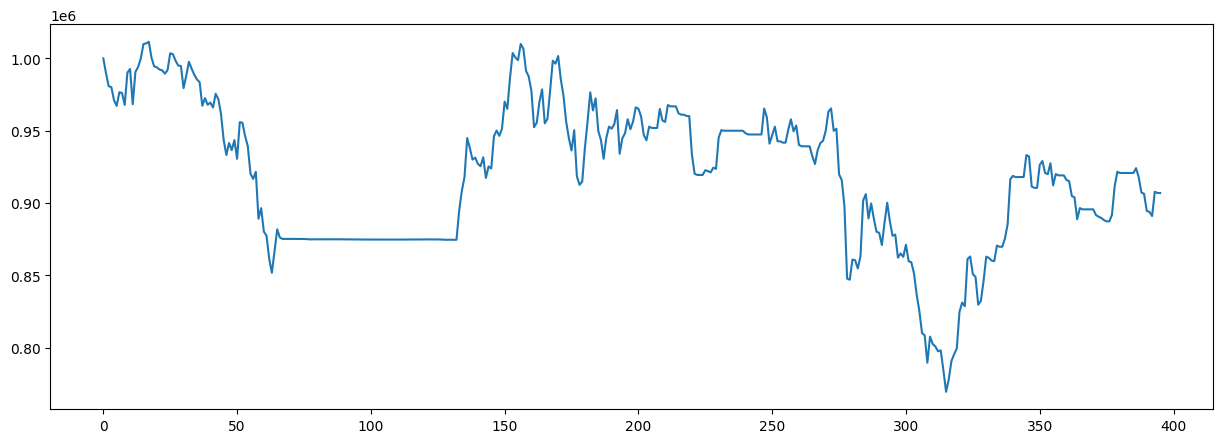

In [163]:
%matplotlib inline
df_account_value.account_value.plot()

In [164]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.060286
Cumulative returns    -0.093089
Annual volatility      0.175744
Sharpe ratio          -0.266923
Calmar ratio          -0.252046
Stability              0.122999
Max drawdown          -0.239186
Omega ratio            0.948128
Sortino ratio         -0.375073
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.066614
Daily value at risk   -0.022328
dtype: float64


In [165]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (414, 8)
Annual return          0.034203
Cumulative returns     0.056806
Annual volatility      0.163092
Sharpe ratio           0.288356
Calmar ratio           0.182205
Stability              0.370123
Max drawdown          -0.187719
Omega ratio            1.053017
Sortino ratio          0.388076
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.778723
Daily value at risk   -0.020361
dtype: float64


In [166]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")
df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2018-02-02  1.000000e+06
1    2018-02-05  9.539511e+05
2    2018-02-06  9.761689e+05
3    2018-02-07  9.754080e+05
4    2018-02-08  9.349358e+05
..          ...           ...
391  2019-09-20  1.004229e+06
392  2019-09-23  1.014806e+06
393  2019-09-24  1.010068e+06
394  2019-09-25  1.020185e+06
395  2019-09-26  1.032965e+06

[396 rows x 2 columns]
df_dji:                       dji
date                    
2018-02-02  1.000000e+06
2018-02-05  9.539511e+05
2018-02-06  9.761689e+05
2018-02-07  9.754080e+05
2018-02-08  9.349358e+05
...                  ...
2019-09-20  1.004229e+06
2019-09-23  1.014806e+06
2019-09-24  1.010068e+06
2019-09-25  1.020185e+06
2019-09-26  1.032965e+06

[396 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2018-01-02
1    2018-01-03
2    2018-01-04
3    2018-01-05
4    2018-01-08
..          ...
478  2019-12-24
479  2019-12-26
480  2019-12-27
481  2019-12-30
482  2019-12-31

[483 rows x 1 columns]
df_result_ensemble:                    ensemble
date                      
2018-02-02  1000000.000000
2018-02-05   989799.733144
2018-02-06   980801.803976
2018-02-07   980127.288972
2018-02-08   971076.851472
...                    ...
2019-09-20   893926.589357
2019-09-23   891004.215781
2019-09-24   907781.956702
2019-09-25   906932.179624
2019-09-26   906911.192330

[396 rows x 1 columns]
==============Compare to DJIA===========
result:                    ensemble           dji
date                                    
2018-02-02  1000000.000000  1.000000e+06
2018-02-05   989799.733144  9.539511e+05
2018-02-06   980801.803976  9.761689e+05
2018-02-07   980127.288972  9.754080e+05
2018-02-08 

<Figure size 1500x500 with 0 Axes>

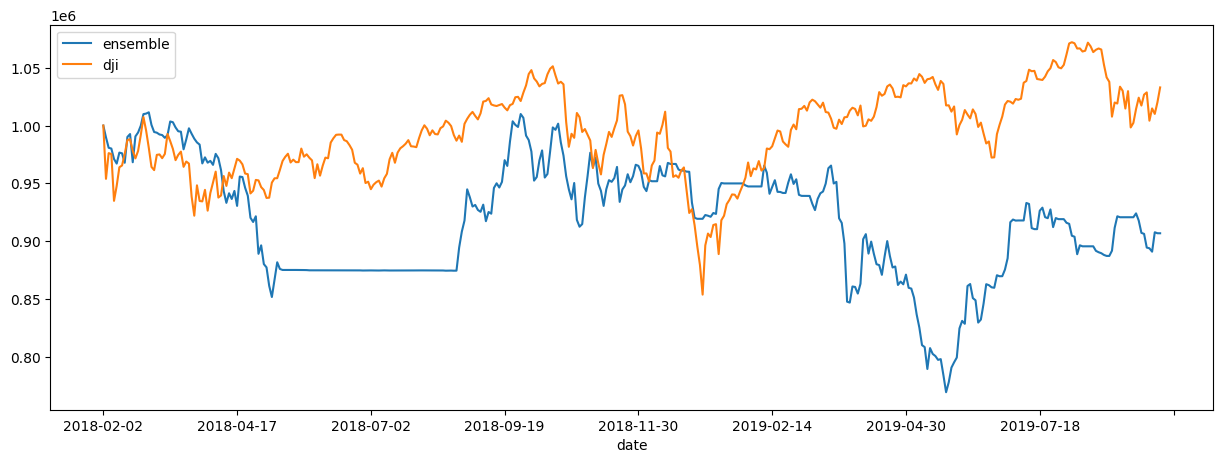

In [167]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();